In [1]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers as l

from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split 

columns = ['T_e','T_bb','tau_T','E','Mu','I','U']
DF_full = pd.read_csv(r"C:\Users\togali\Documents\Python Scripts\Project\data_AMP_PCS.csv", names=columns )
DF_full.drop(index=DF_full.index[0], axis=0, inplace=True)
print(DF_full.shape)
DF_full.dropna(inplace=True)
print(DF_full.shape)

(18874350, 7)
(18874350, 7)


In [88]:
# This function splits dataframe to Test and Train set. I don't split it to validation on my own,
# because TensorFlow has build-in splitting in model.fit() function
def Split_DS(DF,train=0.7):
    X = DF.drop(['I','U'],axis=1)
    Y = pd.DataFrame(np.log(DF['I']))
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=0,train_size=train,shuffle=True)
    return(X_train,X_test,Y_train,Y_test)

def gib_callback(patience=50,start_from=20):
    callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        verbose=0,
        mode='auto',
        baseline=None,
        restore_best_weights=True,
        start_from_epoch=start_from)
    return(callback)


def get_schedule(batch_size,epochs,initial_lr,final_lr,train_size):
    learning_rate_decay_factor = (final_lr / initial_lr)**(1/epochs)
    steps_per_epoch = int(train_size/batch_size)

    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                    initial_learning_rate=initial_lr,
                    decay_steps=steps_per_epoch,
                    decay_rate=learning_rate_decay_factor,
                    staircase=True)
    return(lr_schedule)

a_fn = 'sigmoid'
model1 = [l.Input(5),l.Dense(128,activation=a_fn),l.Dropout(0.04),l.Dense(32,activation=a_fn),l.Dense(1)]
model2 = [l.Input(5),l.Dense(52,activation=a_fn),l.Dropout(0.1),l.Dense(16,activation=a_fn),
          l.Dense(56,activation=a_fn),l.Dense(1)]
model3 = [l.Input(5),l.Dense(28,activation=a_fn),l.Dense(22,activation=a_fn),
          l.Dense(8,activation=a_fn),l.Dense(16,activation=a_fn),l.Dense(1)]
models = [(model1,4929),(model2,2169),(model3,1151)]

45/45 [==============================] - 0s 1ms/step


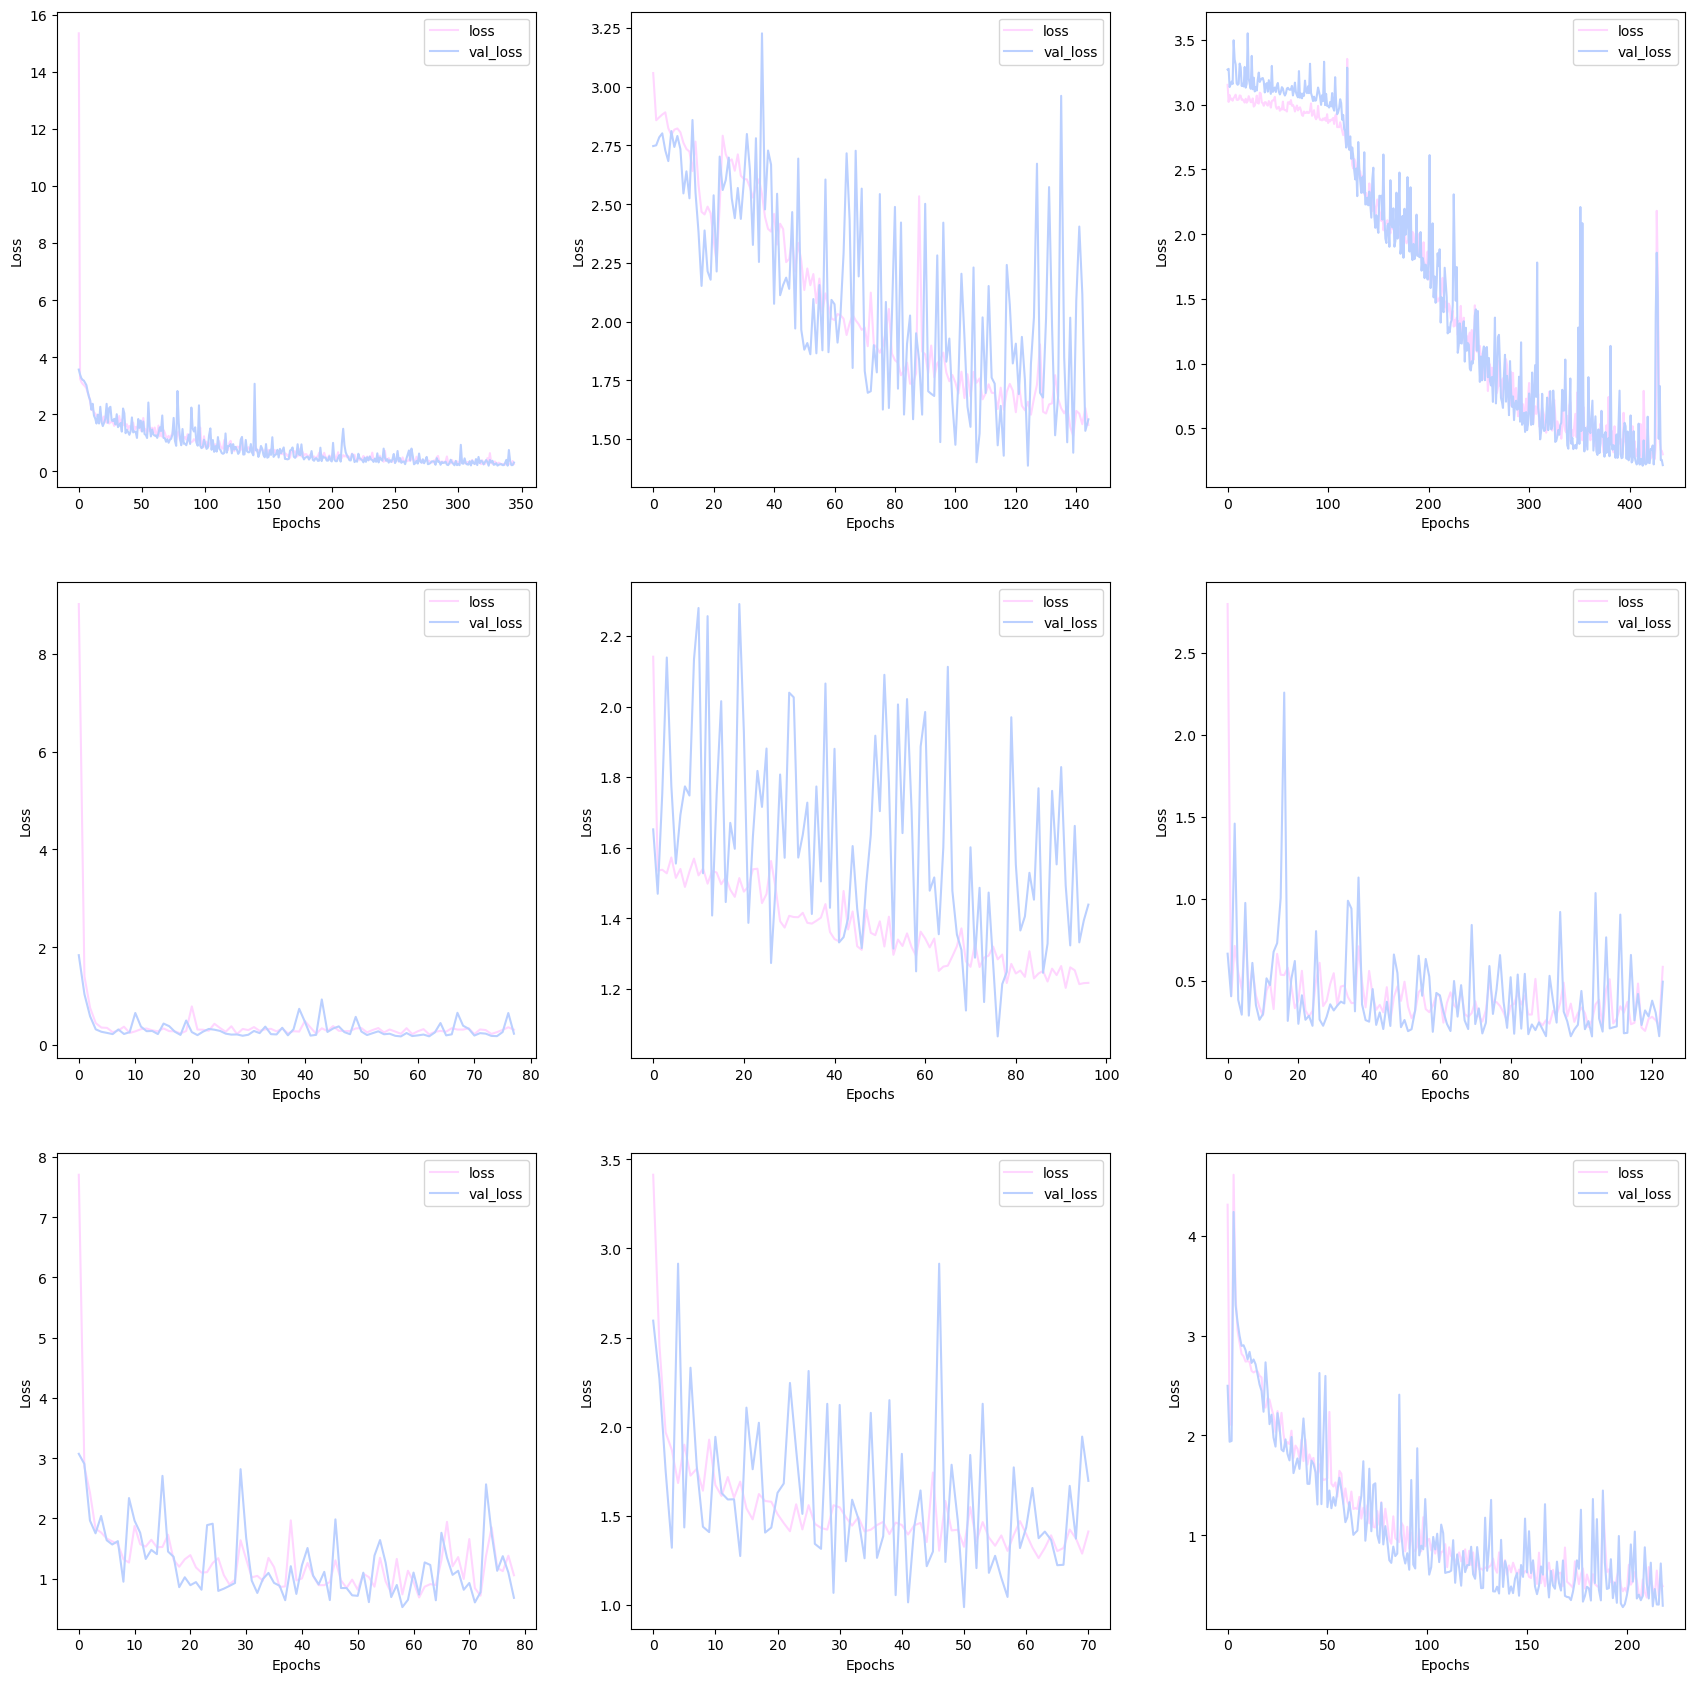

In [83]:
DF_30k = DF_full.sample(30000,random_state=0)
X_train,X_test,Y_train,Y_test = Split_DS(DF_30k)
DF_30k.dropna(inplace=True)

H = []

LRs = [get_schedule(200,1500,0.01,0.00005,len(X_train)),
      get_schedule(200,1500,0.005,0.00005,len(X_train)),
      get_schedule(200,1500,0.01,0.0005,len(X_train))]

BSs = [200]

for lr in LRs:
    for bs in BSs:
        for nn,c in models:
            model = Sequential(nn)
            model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer = tf.keras.optimizers.Adam(learning_rate=lr))

            history = model.fit(X_train,Y_train,epochs=1500,validation_split=0.20,verbose=0,
                                    callbacks=[gib_callback(20,30)],batch_size=bs)
            
            pred = model.predict(X_test,batch_size=200)
            mae  = mean_absolute_error(Y_test.values,pred)
            H.append((history,[c,lr,bs],mae,))
            
            
f,ax = plt.subplots(nrows=3,ncols=3,figsize=[21,21])

for i,hist in enumerate(H):
    cls = ['#ffd6ff','#bbd0ff']
    ax[i//3][i%3].plot(hist[0].epoch,hist[0].history['loss'],color=cls[0])
    ax[i//3][i%3].plot(hist[0].epoch,hist[0].history['val_loss'],color=cls[1])
    ax[i//3][i%3].legend(['loss','val_loss'])
    ax[i//3][i%3].set_xlabel('Epochs')
    ax[i//3][i%3].set_ylabel('Loss')

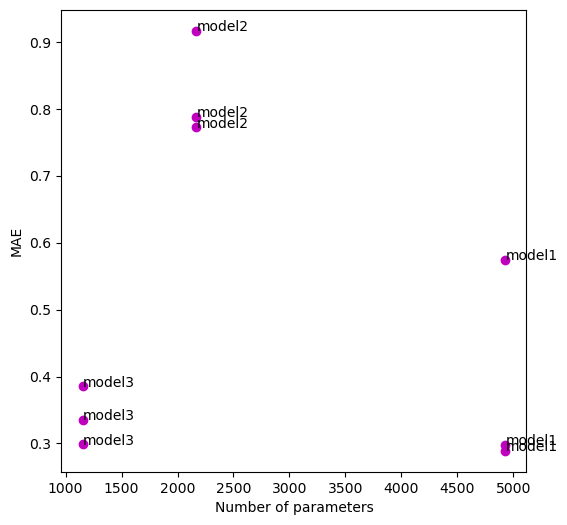

In [87]:
ntn = {4929:'model1',2169:'model2',1151:'model3'}
f,ax = plt.subplots(figsize=[6,6])
for h in H:
    ax.scatter(h[1][0],h[2],color='m')
    ax.set_xlabel('Number of parameters')
    ax.set_ylabel('MAE')
    ax.text(h[1][0],h[2],ntn[h[1][0]])

In [ ]:
#It can be seen that model1 performs the best (although model 3 is close), model2 is the worst.
#some extra refinement of the parameters might be needed